<a href="https://colab.research.google.com/github/DandyWahyu/Machine_Learning/blob/main/Jobsheet10/Jobsheet10_Praktikum1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Dandy Wahyu S
##Kelas : 3A-TI
##Mata Kuliah : Machine Learning

In [1]:
# Impor matplotlib dan buat fungsi pembantu untuk memplot grafik
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [2]:
# Setup input pipeline
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
# Awalnya ini mengembalikan dataset (teks, pasangan label)
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [4]:
# Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Holy freaking God all-freaking-mighty. This movie was so bad, I thought I was on drugs. In a bad way... The character acting is the poorest thing I've seen in quite some time. This movie was more akin to Lord of the G-Strings, IMHO(it's a real movie). Most of the movie appeared to be done on a horrible green screen. My favorite part was when they are in the carriage, and you can tell there's no horse. They're fleeing from alien monsters, and going about the same speed as a swift jog. Then it switches to a far-shot with a ridiculous CG horse. And the CG in general seems to be sub-par to 1992's Beyond the Mind's Eye. I mean, Come on, really. It felt like a horrible episode of Hercules, only without Kevin Sorbo there to save the day. Worst. Movie. Ever."
 b"An uptight voyeur who wants to commit suicide encounters a free spirited bad-seed who has 5 weeks to live and then they're off to discover America. Get the idea? There's not an original moment in this whole movie."
 b'<br />

In [5]:
# Buat Teks Encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [6]:
# Metode .adapt mengatur kosakata lapisan. 20 token pertama
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:
# Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1, 590, ...,   0,   0,   0],
       [ 34,   1,   1, ...,   0,   0,   0],
       [ 13,  13, 401, ...,   0,   0,   0]])

In [8]:
# Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Holy freaking God all-freaking-mighty. This movie was so bad, I thought I was on drugs. In a bad way... The character acting is the poorest thing I've seen in quite some time. This movie was more akin to Lord of the G-Strings, IMHO(it's a real movie). Most of the movie appeared to be done on a horrible green screen. My favorite part was when they are in the carriage, and you can tell there's no horse. They're fleeing from alien monsters, and going about the same speed as a swift jog. Then it switches to a far-shot with a ridiculous CG horse. And the CG in general seems to be sub-par to 1992's Beyond the Mind's Eye. I mean, Come on, really. It felt like a horrible episode of Hercules, only without Kevin Sorbo there to save the day. Worst. Movie. Ever."
Round-trip:  [UNK] [UNK] god [UNK] this movie was so bad i thought i was on [UNK] in a bad way the character acting is the [UNK] thing ive seen in quite some time this movie was more [UNK] to [UNK] of the [UNK] [UNK] a real m

In [9]:
# Buat Model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [10]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [11]:
# evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.0080886]


In [12]:
# evaluasi lagi dalam batch dengan kalimat yang lebih panjang
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 64ms/step
[-0.0080886]


In [13]:
# compile model Keras untuk mengonfigurasi proses pelatihan
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Epoch 1/10
391/391 [==============================] - 54s 107ms/step - loss: 0.6386 - accuracy: 0.5702 - val_loss: 0.4693 - val_accuracy: 0.7776
Epoch 2/10
391/391 [==============================] - 28s 72ms/step - loss: 0.4599 - accuracy: 0.7794 - val_loss: 0.3999 - val_accuracy: 0.8297
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3650 - accuracy: 0.8410 - val_loss: 0.3645 - val_accuracy: 0.8557
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3321 - accuracy: 0.8559 - val_loss: 0.3469 - val_accuracy: 0.8354
Epoch 5/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3178 - accuracy: 0.8630 - val_loss: 0.3377 - val_accuracy: 0.8464
Epoch 6/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3086 - accuracy: 0.8690 - val_loss: 0.3259 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3036 - accuracy: 0.8705 - val_loss: 0.3292 - val_accuracy

(0.0, 0.6558322057127952)

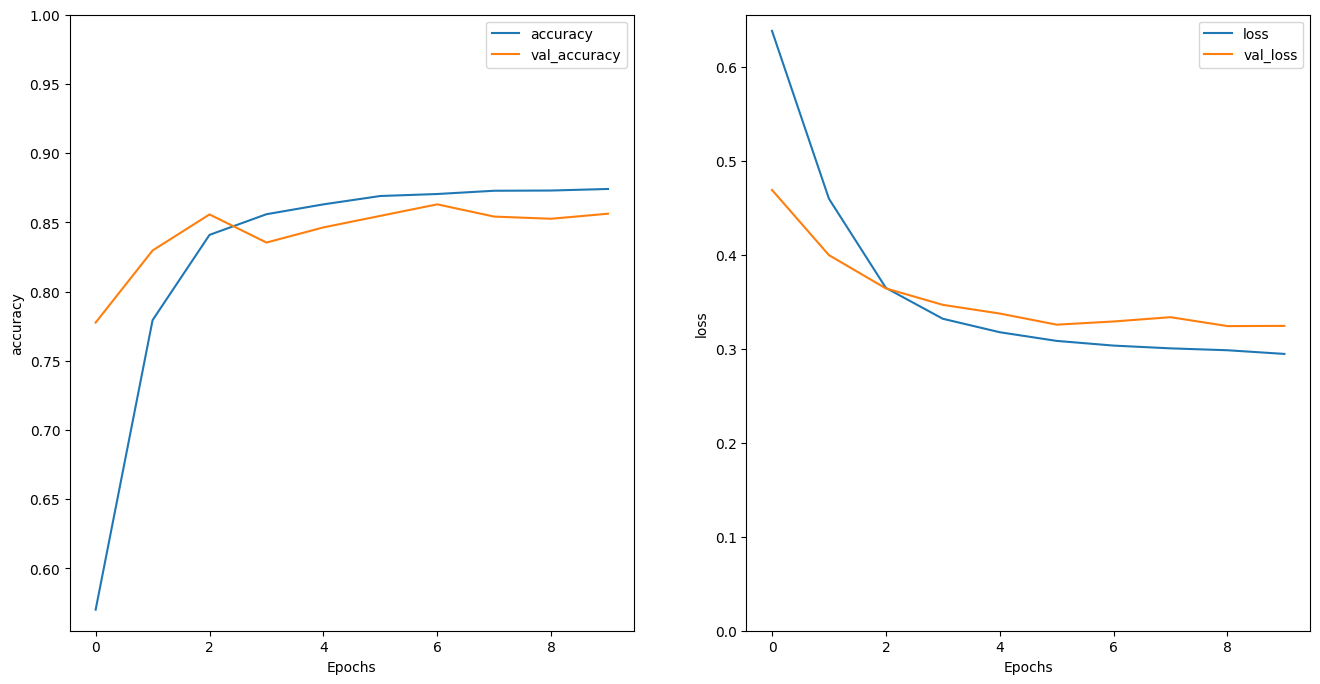

In [14]:
# Train Model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [15]:
# Jalankan prediksi pada kalimat baru
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [16]:
# Stack two or more LSTM layers
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3268 - accuracy: 0.8636 - val_loss: 0.3349 - val_accuracy: 0.8432
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3189 - accuracy: 0.8669 - val_loss: 0.3237 - val_accuracy: 0.8536
Epoch 3/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3102 - accuracy: 0.8708 - val_loss: 0.3219 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3098 - accuracy: 0.8708 - val_loss: 0.3187 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3026 - accuracy: 0.8758 - val_loss: 0.3301 - val_accuracy: 0.8620
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3016 - accuracy: 0.8758 - val_loss: 0.3195 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3018 - accuracy: 0.8736 - val_loss: 0.3309 - val_ac

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3199 - accuracy: 0.8585
Test Loss: 0.31985217332839966
Test Accuracy: 0.858519971370697


In [21]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.6650659]]


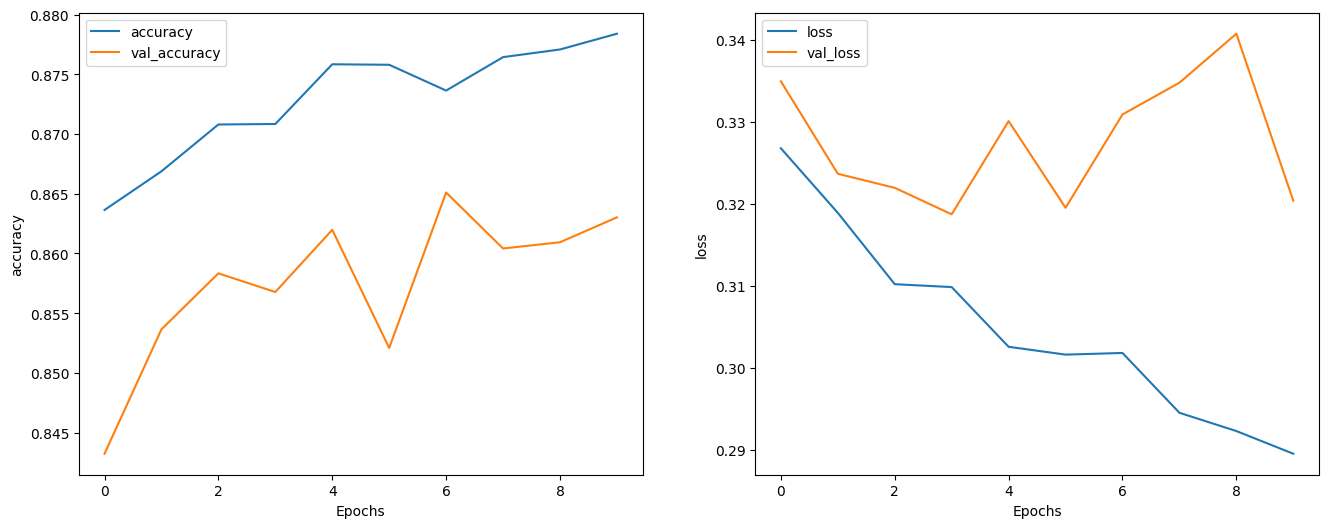

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')